In [1]:
import numpy as np
from scipy.fftpack import dct, idct
from PIL import Image
from skimage.metrics import mean_squared_error
from math import sqrt
import heapq
import collections
import matplotlib.pyplot as plt
from collections import defaultdict

In [2]:
# Helper Functions
def compression_ratio(original_size, compressed_size):
    return original_size / compressed_size

def calculate_rmse(original, reconstructed):
    mse = mean_squared_error(original, reconstructed)
    return sqrt(mse)

In [3]:
# Transform Coding (using DCT)
def dct2d(block):
    return dct(dct(block.T, norm='ortho').T, norm='ortho')

def idct2d(block):
    return idct(idct(block.T, norm='ortho').T, norm='ortho')

def transform_coding_dct(image, block_size=8):
    h, w = image.shape
    dct_blocks = np.zeros_like(image, dtype=float)
    quantization_factor = 10  # Example quantization factor

    # Forward DCT and quantization
    for i in range(0, h, block_size):
        for j in range(0, w, block_size):
            block = image[i:i+block_size, j:j+block_size]
            dct_block = dct2d(block)
            dct_blocks[i:i+block_size, j:j+block_size] = np.round(dct_block / quantization_factor)

    # Calculate compression ratio and RMSE
    compressed_size = np.count_nonzero(dct_blocks)
    original_size = h * w
    reconstructed = np.zeros_like(image, dtype=float)

    # Reconstruct using inverse DCT
    for i in range(0, h, block_size):
        for j in range(0, w, block_size):
            block = dct_blocks[i:i+block_size, j:j+block_size] * quantization_factor
            reconstructed[i:i+block_size, j:j+block_size] = idct2d(block)

    cr = compression_ratio(original_size, compressed_size)
    rmse = calculate_rmse(image, reconstructed)
    return dct_blocks, reconstructed, cr, rmse


In [4]:
# Huffman Encoding
class HuffmanNode:
    def __init__(self, symbol, freq):
        self.symbol = symbol
        self.freq = freq
        self.left = None
        self.right = None

    def __lt__(self, other):
        return self.freq < other.freq

def huffman_tree(frequencies):
    heap = [HuffmanNode(symbol, freq) for symbol, freq in frequencies.items()]
    heapq.heapify(heap)
    while len(heap) > 1:
        left = heapq.heappop(heap)
        right = heapq.heappop(heap)
        merged = HuffmanNode(None, left.freq + right.freq)
        merged.left = left
        merged.right = right
        heapq.heappush(heap, merged)
    return heap[0]

def huffman_codes(tree):
    def generate_codes(node, prefix=""):
        if node.symbol is not None:
            return {node.symbol: prefix}
        left_codes = generate_codes(node.left, prefix + "0")
        right_codes = generate_codes(node.right, prefix + "1")
        return {**left_codes, **right_codes}
    return generate_codes(tree)

def huffman_encoding(image):
    frequencies = collections.Counter(image.flatten())
    tree = huffman_tree(frequencies)
    codes = huffman_codes(tree)

    encoded_image = ''.join(codes[pixel] for pixel in image.flatten())
    compressed_size = len(encoded_image)
    original_size = image.size * 8
    cr = compression_ratio(original_size, compressed_size)

    return encoded_image, codes, cr

def huffman_decoding(encoded_image, codes):
    reverse_codes = {v: k for k, v in codes.items()}
    current_code = ""
    decoded_image = []

    for bit in encoded_image:
        current_code += bit
        if current_code in reverse_codes:
            decoded_image.append(reverse_codes[current_code])
            current_code = ""
    
    return np.array(decoded_image).reshape(-1)


In [5]:
# LZW Encoding
def lzw_encode(data):
    dictionary = {chr(i): i for i in range(256)}
    p = ""
    output = []
    code = 256

    for c in data:
        pc = p + c
        if pc in dictionary:
            p = pc
        else:
            output.append(dictionary[p])
            dictionary[pc] = code
            code += 1
            p = c
    if p:
        output.append(dictionary[p])
    return output, dictionary

def lzw_decode(encoded_data, dictionary):
    reverse_dictionary = {v: k for k, v in dictionary.items()}
    p = chr(encoded_data[0])
    decoded_data = [p]

    for code in encoded_data[1:]:
        if code in reverse_dictionary:
            entry = reverse_dictionary[code]
        else:
            entry = p + p[0]
        decoded_data.append(entry)
        p = entry

    return ''.join(decoded_data)

def lzw_encoding(image):
    flat_image = ''.join(map(chr, image.flatten()))
    encoded_data, dictionary = lzw_encode(flat_image)
    compressed_size = len(encoded_data) * 12  # Assuming 12-bit codes
    original_size = image.size * 8
    cr = compression_ratio(original_size, compressed_size)

    return encoded_data, dictionary, cr

def lzw_decoding(encoded_data, dictionary):
    flat_image = lzw_decode(encoded_data, dictionary)
    return np.array(list(map(ord, flat_image))).reshape(-1)


In [6]:
# Run-Length Encoding
def run_length_encode(image):
    flat_image = image.flatten()
    encoded = []
    prev_pixel = flat_image[0]
    count = 1

    for pixel in flat_image[1:]:
        if pixel == prev_pixel:
            count += 1
        else:
            encoded.extend([prev_pixel, count])
            prev_pixel = pixel
            count = 1
    encoded.extend([prev_pixel, count])  # for the last run
    compressed_size = len(encoded) * 8
    original_size = image.size * 8
    cr = compression_ratio(original_size, compressed_size)
    return encoded, cr

def run_length_decode(encoded):
    decoded = []
    it = iter(encoded)
    for pixel, count in zip(it, it):
        decoded.extend([pixel] * count)
    return np.array(decoded)



--- Compression Results ---
Transform Coding (DCT): Compression Ratio = 2.86, RMSE = 1.92
Huffman Encoding: Compression Ratio = 1.04
LZW Encoding: Compression Ratio = 1.25
Run-Length Encoding: Compression Ratio = 0.57
RMSE (Huffman Decoding): 0.00
RMSE (LZW Decoding): 0.00
RMSE (RLE Decoding): 0.00


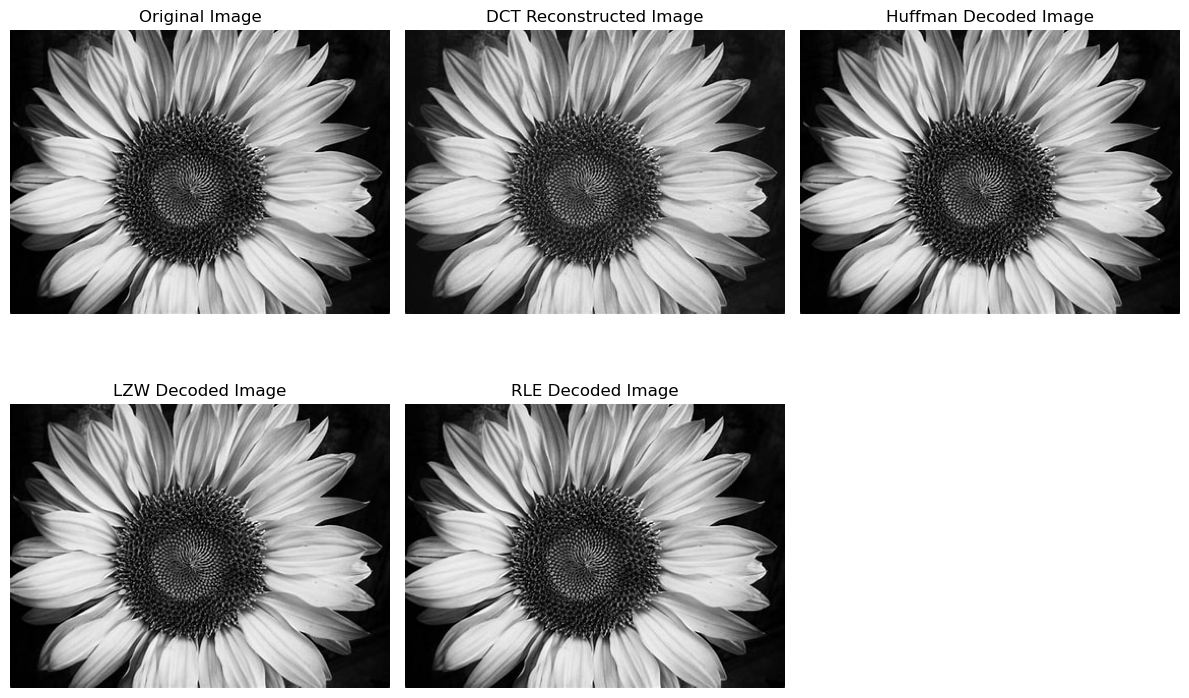

In [8]:
# Main Function 
def compress_image(image_path):
    # Load image in grayscale
    image = Image.open(image_path).convert('L')
    image = np.array(image)

    print("\n--- Compression Results ---")

    # A. Transform Coding (DCT)
    _, reconstructed_dct, dct_cr, dct_rmse = transform_coding_dct(image)
    print(f"Transform Coding (DCT): Compression Ratio = {dct_cr:.2f}, RMSE = {dct_rmse:.2f}")

    # B. Huffman Encoding
    encoded_huffman, huffman_codes, huffman_cr = huffman_encoding(image)
    print(f"Huffman Encoding: Compression Ratio = {huffman_cr:.2f}")
    decoded_huffman = huffman_decoding(encoded_huffman, huffman_codes)

    # C. LZW Encoding
    encoded_lzw, lzw_dict, lzw_cr = lzw_encoding(image)
    print(f"LZW Encoding: Compression Ratio = {lzw_cr:.2f}")
    decoded_lzw = lzw_decoding(encoded_lzw, lzw_dict)

    # D. Run-Length Encoding
    encoded_rle, rle_cr = run_length_encode(image)
    print(f"Run-Length Encoding: Compression Ratio = {rle_cr:.2f}")
    decoded_rle = run_length_decode(encoded_rle)

    # RMSE for decoded images (for Huffman, LZW, RLE)
    rmse_huffman = calculate_rmse(image, decoded_huffman.reshape(image.shape))
    rmse_lzw = calculate_rmse(image, decoded_lzw.reshape(image.shape))
    rmse_rle = calculate_rmse(image, decoded_rle.reshape(image.shape))

    print(f"RMSE (Huffman Decoding): {rmse_huffman:.2f}")
    print(f"RMSE (LZW Decoding): {rmse_lzw:.2f}")
    print(f"RMSE (RLE Decoding): {rmse_rle:.2f}")

    # Show original and compressed images
    plt.figure(figsize=(12, 8))

    # Original Image
    plt.subplot(2, 3, 1)
    plt.title("Original Image")
    plt.imshow(image, cmap='gray')
    plt.axis('off')

    # DCT Compressed Image
    plt.subplot(2, 3, 2)
    plt.title("DCT Reconstructed Image")
    plt.imshow(reconstructed_dct, cmap='gray')
    plt.axis('off')

    # Huffman Decoded Image
    plt.subplot(2, 3, 3)
    plt.title("Huffman Decoded Image")
    plt.imshow(decoded_huffman.reshape(image.shape), cmap='gray')
    plt.axis('off')

    # LZW Decoded Image
    plt.subplot(2, 3, 4)
    plt.title("LZW Decoded Image")
    plt.imshow(decoded_lzw.reshape(image.shape), cmap='gray')
    plt.axis('off')

    # RLE Decoded Image
    plt.subplot(2, 3, 5)
    plt.title("RLE Decoded Image")
    plt.imshow(decoded_rle.reshape(image.shape), cmap='gray')
    plt.axis('off')

    plt.tight_layout()
    plt.show()


# Example usage
if __name__ == "__main__":
    compress_image("image.jpeg")

In [9]:
# Function to calculate the frequency distribution of symbols (pixel values)
def calculate_frequencies(image):
    freq = defaultdict(int)
    total_pixels = image.size
    for pixel in image.ravel():
        freq[pixel] += 1
    return {k: v / total_pixels for k, v in freq.items()}

# Function for arithmetic encoding
def arithmetic_encode(image, freq_distribution):
    low, high = 0.0, 1.0
    for pixel in image.ravel():
        range_width = high - low
        cumulative_probability = sum(v for k, v in freq_distribution.items() if k < pixel)
        low = low + range_width * cumulative_probability
        high = low + range_width * freq_distribution[pixel]
    return (low + high) / 2  # Final encoded value

# Function for arithmetic decoding
def arithmetic_decode(encoded_value, freq_distribution, image_shape):
    decoded_image = np.zeros(image_shape, dtype=int)
    low, high = 0.0, 1.0
    for i in range(image_shape[0] * image_shape[1]):
        range_width = high - low
        value = (encoded_value - low) / range_width
        cumulative_sum = 0.0
        for pixel, probability in freq_distribution.items():
            cumulative_sum += probability
            if value < cumulative_sum:
                decoded_image[i // image_shape[1], i % image_shape[1]] = pixel
                high = low + range_width * cumulative_sum
                low = low + range_width * (cumulative_sum - probability)
                break
    return decoded_image

# Example usage
if __name__ == "__main__":
    # Load an image as a 2D array (for simplicity, grayscale)
    sample_image = np.array([[52, 55, 61], [53, 54, 52], [54, 53, 53]], dtype=int)
    freq_distribution = calculate_frequencies(sample_image)

    encoded_value = arithmetic_encode(sample_image, freq_distribution)
    decoded_image = arithmetic_decode(encoded_value, freq_distribution, sample_image.shape)

    print("Original Image:\n", sample_image)
    print("Encoded Value:", encoded_value)
    print("Decoded Image:\n", decoded_image)

Original Image:
 [[52 55 61]
 [53 54 52]
 [54 53 53]]
Encoded Value: 0.1959337158340121
Decoded Image:
 [[52 54 53]
 [52 55 54]
 [52 54 61]]
